In [1]:
#
# Description: This file runs the main function of the project so we can analyze the results of the different models.
#
# Authors: Christoforou Anthony, ARM Ethan
# Date: 24/06/2023
#
# License: GNU GPL v3.0
#
# This file is part of the Data Mining final project of the University of Geneva.
#

# Predicting Active Wind Power: Model Comparison and Evaluation

Welcome to this Jupyter Notebook, where we will present the results of our efforts in predicting active wind power using various machine learning models. Wind power is a crucial renewable energy source, and accurate prediction of its active power generation is vital for efficient grid management and integration of wind farms.

In this project, we have explored and trained multiple models on historical wind power data, with the aim of predicting the active power output based on various input features such as wind speed, temperature, and atmospheric pressure. Our objective is to identify the most effective model that can provide accurate and reliable predictions for real-time wind power forecasting.

### Dataset

The dataset used in this project was collected from the Supervisory Control and Data Acquisition (SCADA) system of a wind farm. The SCADA data was sampled every 10 minutes from each of the 134 wind turbines in the wind farm, resulting in a total of 4,727,520 records spanning a duration of 245 days. The dataset provides valuable information on wind power generation as well as meteorological and environmental features. By leveraging this rich dataset, we aim to train and evaluate machine learning models for predicting the active wind power output based on the available input features.

### Models

Throughout our analysis, we have explored a range of models, each with its own strengths and characteristics. These models include:

- KNearest Neighbours (**BASELINE**)
- Logistic Regression
- Random Forest Regression
- Long Short-Term Memory (LSTM) Neural Network

Each model brings unique features and capabilities to the table, and we have tailored their configurations to best suit the task of wind power prediction. By comparing and evaluating the performance of these models, we aim to identify the most effective approach for accurate and reliable forecasting.

### Evaluation Metrics

To assess the performance of each model, we have employed mostly **Root Mean Squared Error (RMSE)** because it provides a more interpretable metric by taking the square root of MSE.

### Conclusion

Through this notebook, we will showcase the results and analyses of our trained models. By comparing their performance using various evaluation metrics, we aim to provide insights into the strengths and weaknesses of each approach. This will help us identify the most effective model for accurate and reliable predictions of active wind power, thereby enabling better planning and utilization of wind energy resources.

Let's proceed to the subsequent sections to dive into the results and evaluations of our trained models.

---

Before starting, let's import everything we need

In [2]:
# Libraries
import torch
import numpy as np
from torch import nn, optim
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Modules
from data import CustomWindFarmDataset
from models import *
from utils import download_data, data_url, relative_position_url, data_dir, relative_position_file

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

---

## Setting up

To begin our analysis and model training, we first need to set up the necessary components and load the dataset. This involves defining the hyperparameters for our models and preparing the dataset for further processing.

### Hyperparameters

Hyperparameters play a crucial role in the performance and behavior of our machine learning models. These parameters are set prior to training and are not learned from the data itself. Here are the hyperparameters we will be considering:

- Learning rate: Determines the step size at each iteration during model optimization.
- Number of hidden layers: Specifies the depth of the neural network architecture.
- Number of units in hidden layers: Controls the complexity and capacity of the model.
- Number of epochs: Defines the number of iterations the model will be trained on the data.
- Batch size: Specifies the number of samples propagated through the network at once.

By carefully selecting appropriate hyperparameters, we can optimize the performance and convergence of our models.

### Dataset Loading

The dataset, as mentioned earlier, consists of 4,727,520 records collected from the SCADA system of a wind farm. Each record contains information sampled every 10 minutes from the 134 wind turbines in the wind farm, as well as corresponding meteorological and environmental features.

To train and evaluate our models, we need to load this dataset into our Jupyter Notebook. We will preprocess the data, perform any necessary feature engineering, and split it into training and validation sets. This will allow us to effectively train our models on a portion of the data and evaluate their performance on unseen samples.

With the hyperparameters set and the dataset loaded, we are ready to proceed with the model training and evaluation. The subsequent sections will delve into the details of each model, their implementation, and the results obtained.

In [3]:
# Download the data if it is not already present
download_data(data_url, data_dir)
download_data(relative_position_url, relative_position_file)

# Check if GPU is available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = "cpu"

print(f"Using {device} device.")

# fixed parameters
SEQ_LEN = 1
INPUT_SIZE = 11
OUTPUT_SIZE = 1

# hyperparameters
LEARNING_RATE = 0.05
HIDDEN_SIZE = 6
NUM_LAYERS = 1
EPOCHS = 200
BATCH_SIZE = 32

# Transforms
transform = StandardScaler()
target_transform = MinMaxScaler()

# Load the dataset
dataset = CustomWindFarmDataset(data_dir, relative_position_file, q=SEQ_LEN, device=device, transform=transform.fit_transform, target_transform=target_transform.fit_transform)

#patv_correlations = dataset.correlations("Patv")
#print("Correlations : ", patv_correlations)

# split the data into train and validation sets
split_size = 0.8 # 80% of the dataset for training
train_size = int(len(dataset)*split_size)

# Create the subsets
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
validation_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

./data/wtbdata_245days.csv already exists.
./data/sdwpf_baidukddcup2022_turb_location.CSV already exists.
Using cpu device.
Cleaning data...
Removing rows with missing values...
Rows with missing values removed.
Removing rows with unknown values...
Rows with unknown values removed.
Removing rows with abnormal values...
Rows with abnormal values removed.
Cleaning done.


---

## Model Evaluation and Results

In this section, we will evaluate the trained models, plot the results, and discuss their performance in predicting the active wind power output.

### Loading the Trained Models

Before proceeding with the evaluation, let's load the trained models that we previously saved. These models have undergone training on the training dataset and are now ready for evaluation on the validation set. By loading the trained models, we can directly use them to make predictions and assess their performance.

In [4]:
# Load the models
knn_model = KNN(device=device)
lreg_model = LogisticRegression(INPUT_SIZE, OUTPUT_SIZE, learning_rate=LEARNING_RATE, device=device)
nn_model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, device=device, learning_rate=LEARNING_RATE)

### Model Evaluation and Predictions

Using the loaded models, we will make predictions on the validation dataset and evaluate their performance using appropriate metrics. The predictions will be compared against the actual values of the active wind power output to assess the accuracy and reliability of each model.

For each model, we will calculate and analyze use the root mean squared error (RMSE) metric, This metric will provide insights into the models' ability to capture the patterns and variability in the wind power data.

In [8]:
# KNN Modeling    
knn_model.train(train_dataloader, validation_dataloader)

# Logistic Regression Modeling
lreg_model.train(train_dataloader, validation_dataloader, epochs=EPOCHS, record_freq=EPOCHS//(EPOCHS//10))

# Neural Network Modeling
#nn_model = LSTM.load('../saved_models/nn_model.pt')
nn_model.train(train_dataloader, validation_dataloader, epochs=EPOCHS, record_freq=EPOCHS//(EPOCHS//10))
nn_model.save('./saved_models/nn_model.pt')

# Random Forest Regression

LogisticRegression Trainining: 100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


Training finished. Final Accuracy: 0.17995977401733398


LSTM Trainining: 100%|██████████| 200/200 [00:48<00:00,  4.12it/s]

Training finished. Final Accuracy: 0.06443440169095993
Saving self to ./saved_models/nn_model.pt.


RuntimeError: Parent directory ./saved_models does not exist.

### Plotting the Results

Visualizing the results is an effective way to gain a deeper understanding of the models' performance. We will create plots to showcase the predicted values against the actual values of the active wind power output. This will allow us to visually compare the models' predictions and observe any patterns or discrepancies.

Additionally, we will plot the training and validation loss curves for each model during the training phase. These curves provide insights into the models' convergence and overfitting tendencies, aiding in the assessment of their training performance.

Not plotabel since there is no loss function
Accuracy: 0.0950852483510971


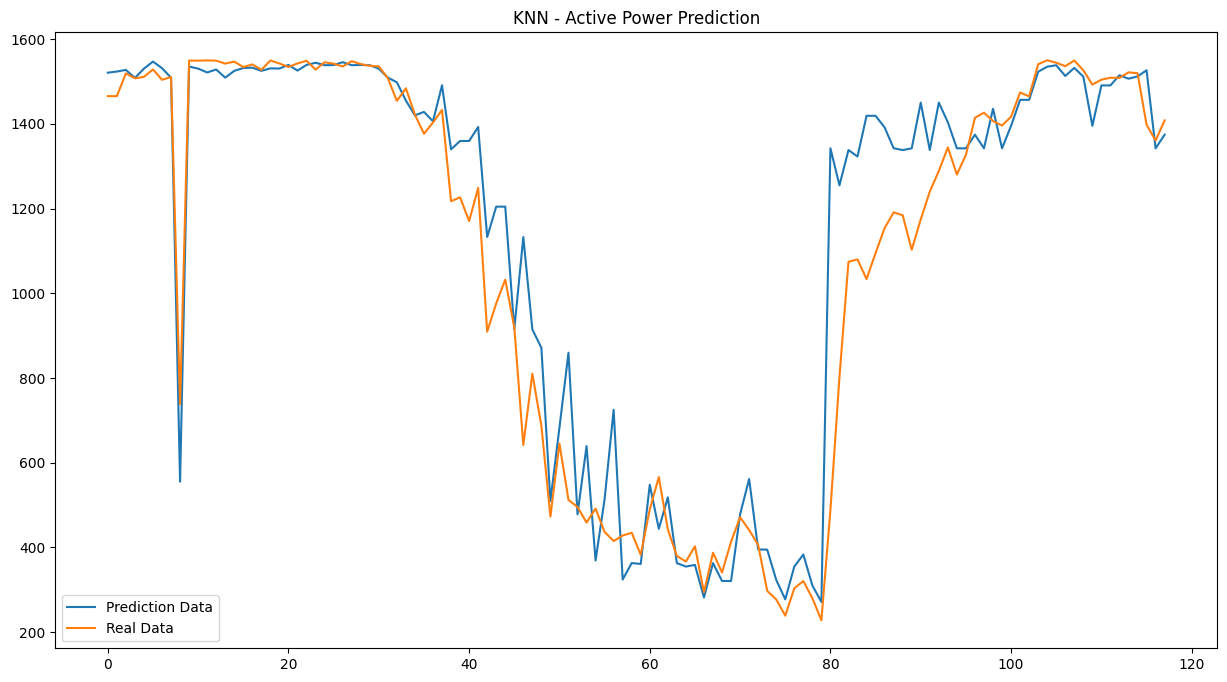

In [9]:
# KNN
print(knn_model.plot_loss())
print(knn_model.plot_accuracy())
knn_model.plot_prediction(validation_dataloader, target_transform=target_transform.inverse_transform)

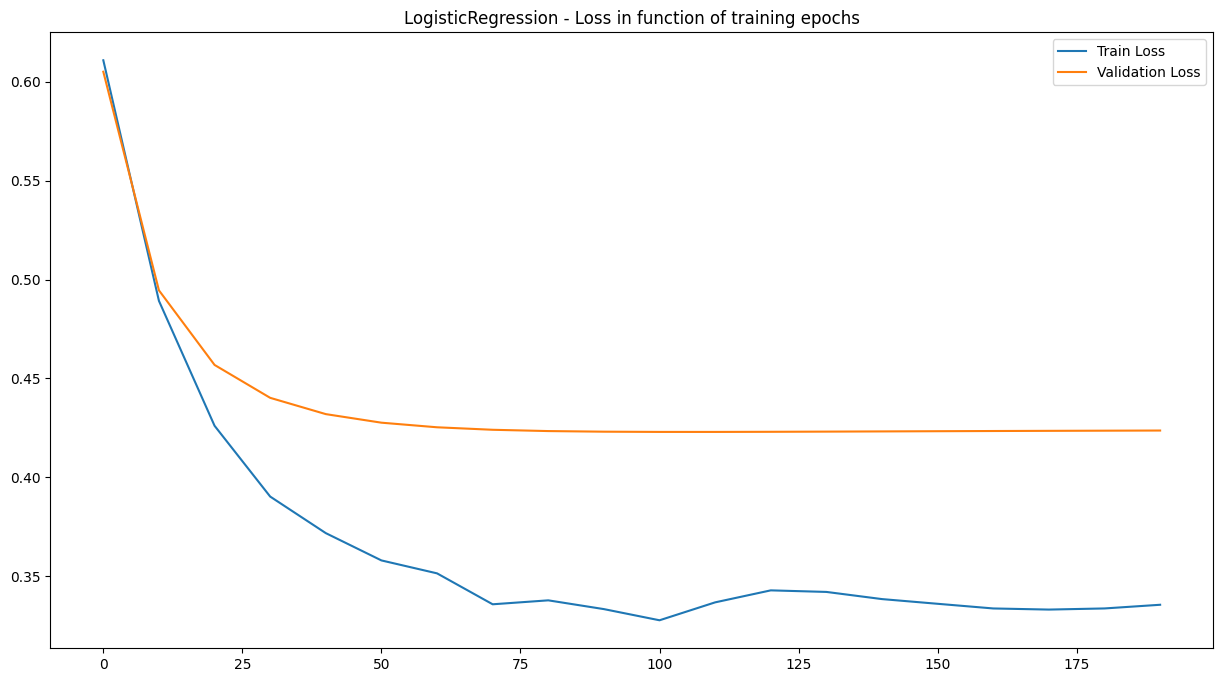

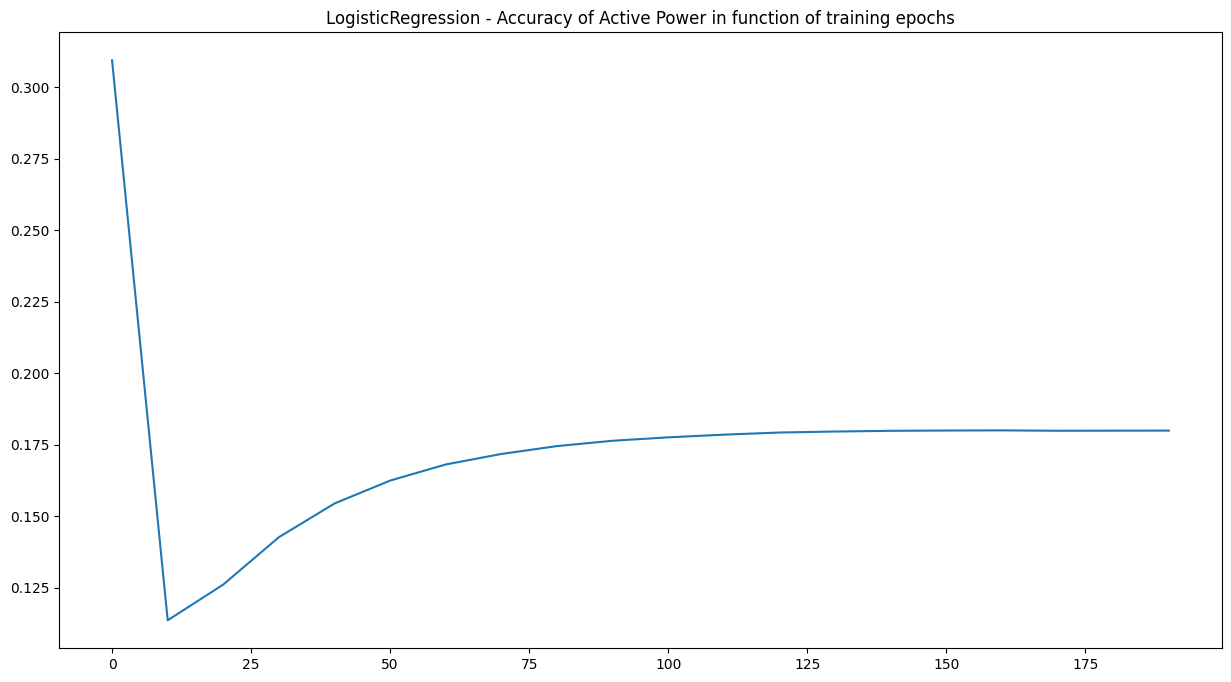

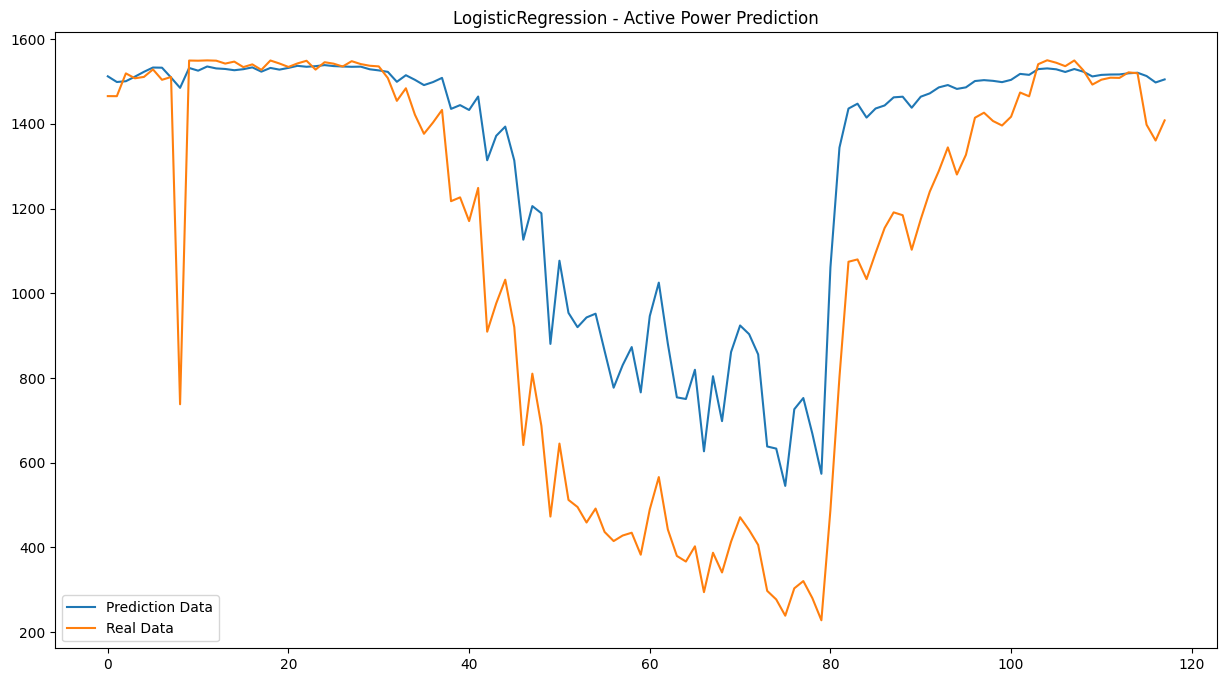

In [10]:
# Logistic Regression
lreg_model.plot_loss()
lreg_model.plot_accuracy()
lreg_model.plot_prediction(validation_dataloader, target_transform=target_transform.inverse_transform)

In [11]:
# Random Forest Regression

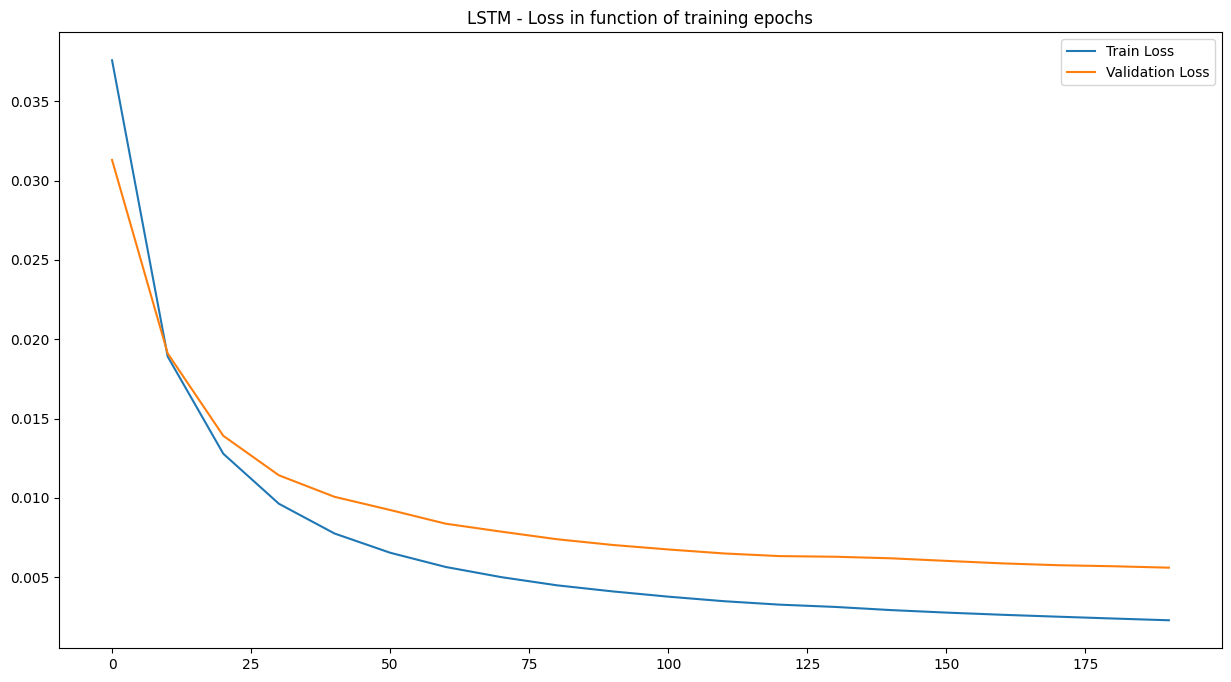

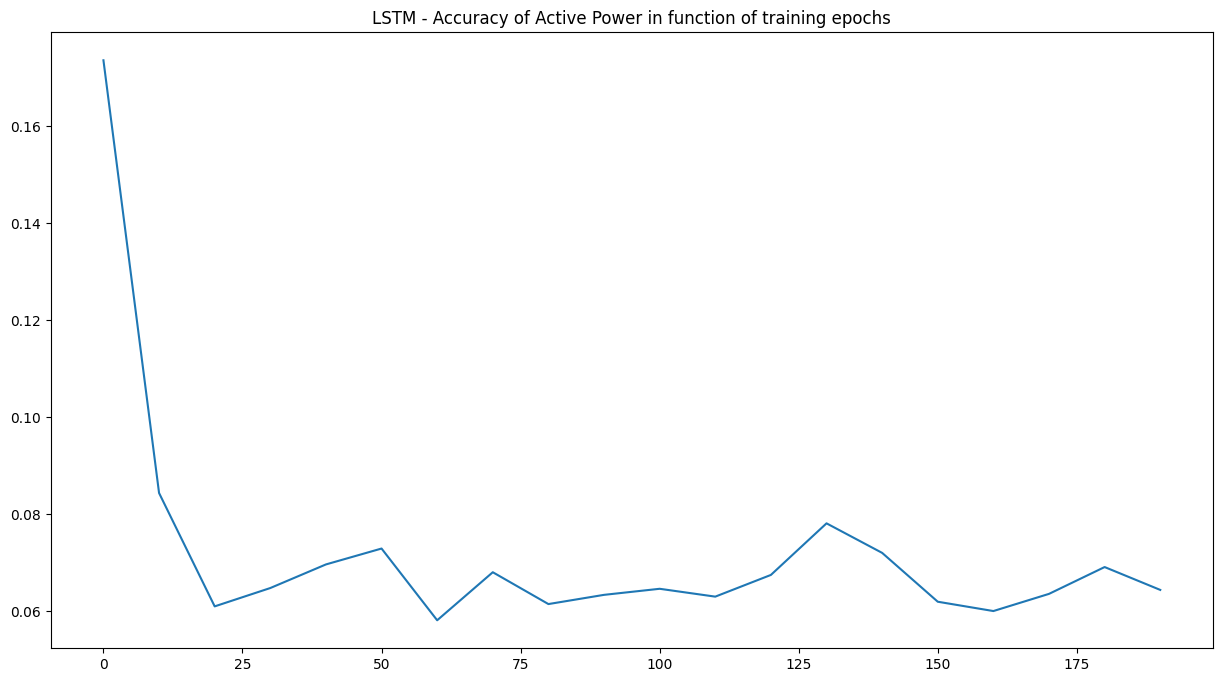

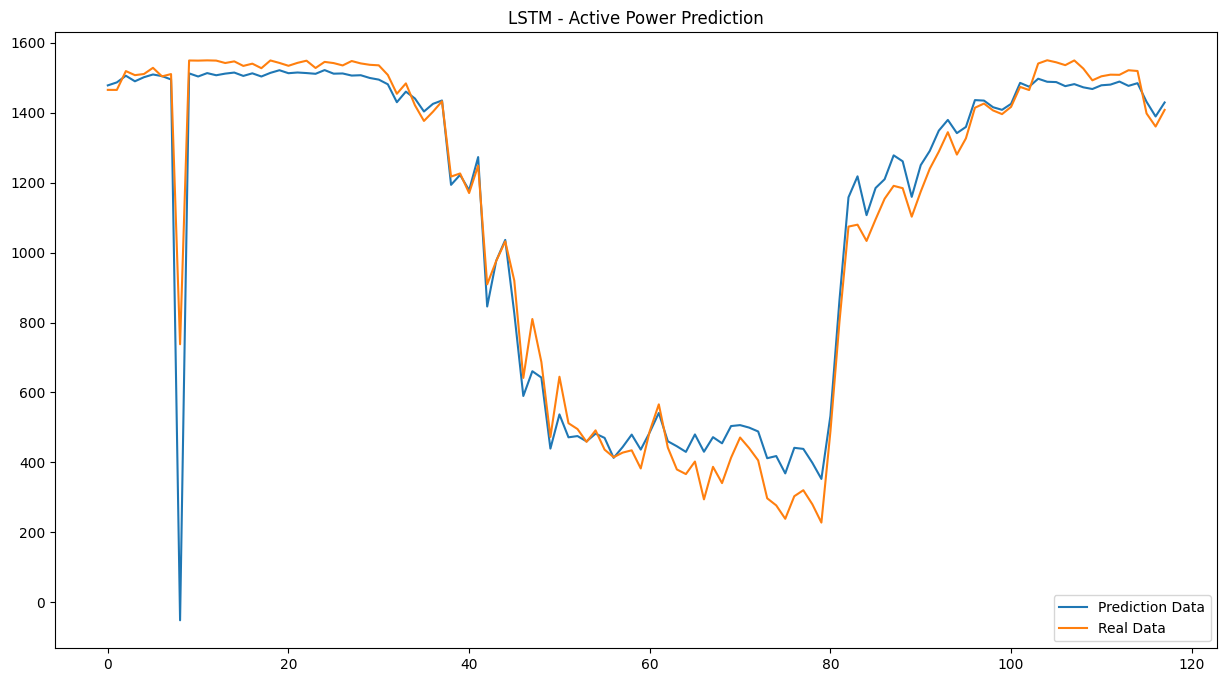

In [12]:
# Neural Network 
nn_model.plot_loss()
nn_model.plot_accuracy()
nn_model.plot_prediction(validation_dataloader, target_transform=target_transform.inverse_transform)